In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-10 17:09:19.449289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-10 17:09:19.823338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-10 17:09:19.823601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-10 17:09:19.825099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-10 17:09:19.826438: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-10 17:09:19.826742: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-10 17:09:19.828423: I tensorflow/stream_executor/platform/d

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_tl.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [4]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
#Defining the CWoLA model
def CWoLA(p_i):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [7]:
#Extracting the data for pretraining
n_train_sr_bkg = 25000
n_train_sr_signal = 25000
files = ['id1','id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'dd10', 'dd20', 
         'dd30', 'dd40', 'dd50'] #Notice that there is no id10 file
rng = np.random.default_rng(seed=42)
for p_1 in [25, 50, 75]:
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    #First jet, background, SR
    bkg_train_1 = bkg_sr_jet_1[0:n_train_sr_bkg]
    #Second jet, background, SR
    bkg_train_2 = bkg_sr_jet_2[0:n_train_sr_bkg]
    
    bkg_train_1 = bkg_train_1.reshape((np.shape(bkg_train_1)[0], p_1, p_1, 1))
    bkg_train_2 = bkg_train_2.reshape((np.shape(bkg_train_2)[0], p_1, p_1, 1))
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    signal_sr_jet_1_total = []
    signal_sr_jet_2_total = []
    for file in files:
        s1 = np.load(f'{file}_sr_{p_1}_jet_1.npy')
        s2 = np.load(f'{file}_sr_{p_1}_jet_2.npy')
        for idx, signal_sr_jet_1 in enumerate(s1): 
            signal_sr_jet_1_total.append(s1[idx])
            signal_sr_jet_2_total.append(s2[idx])
    signal_sr_jet_1_total = np.array(signal_sr_jet_1_total)
    signal_sr_jet_2_total = np.array(signal_sr_jet_2_total)
    
    signal_sr_jet_1_total = signal_sr_jet_1_total.reshape(np.shape(signal_sr_jet_1_total)[0], p_1, p_1, 1)
    signal_sr_jet_2_total = signal_sr_jet_2_total.reshape(np.shape(signal_sr_jet_2_total)[0], p_1, p_1, 1)
    
    
    indices = rng.permutation(np.shape(signal_sr_jet_1_total)[0])
    
    signal_sr_jet_1_total = signal_sr_jet_1_total[indices]
    signal_sr_jet_2_total = signal_sr_jet_2_total[indices]
    
    signal_train_1 = signal_sr_jet_1_total[0:n_train_sr_signal]
    signal_train_2 = signal_sr_jet_2_total[0:n_train_sr_signal]
    
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
        
    #Mix up the samples
    indices_2 = rng.permutation(np.shape(y_train)[0])
        
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]    
    
    cwola = CWoLA(p_1)
    cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/pt_initial_id10_{p_1}.keras')    
    loss_object = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
    cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True)
    history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
    cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/pt_id10_{p_1}.keras')

2024-07-10 16:25:11.395908: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-07-10 16:25:11.426808: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-07-10 16:25:11.429149: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ff3b372aa0 executing computations on platform Host. Devices:
2024-07-10 16:25:11.429190: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-07-10 16:25:11.431545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-10 16:25:11.431677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-10 16:25:11.431707: I tensorflow/strea

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000


2024-07-10 16:25:13.935888: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-10 16:25:14.203287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-10 16:25:14.945221: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


40000/40000 [==============================] - 7s 177us/sample - loss: 0.4938 - accuracy: 0.7638 - val_loss: 0.5391 - val_accuracy: 0.7373
Epoch 2/1000
40000/40000 [==============================] - 4s 110us/sample - loss: 0.3929 - accuracy: 0.8224 - val_loss: 0.4309 - val_accuracy: 0.8021
Epoch 3/1000
40000/40000 [==============================] - 4s 108us/sample - loss: 0.3753 - accuracy: 0.8294 - val_loss: 0.3920 - val_accuracy: 0.8224
Epoch 4/1000
40000/40000 [==============================] - 4s 112us/sample - loss: 0.3655 - accuracy: 0.8338 - val_loss: 0.3614 - val_accuracy: 0.8376
Epoch 5/1000
40000/40000 [==============================] - 4s 111us/sample - loss: 0.3542 - accuracy: 0.8400 - val_loss: 0.3832 - val_accuracy: 0.8279
Epoch 6/1000
40000/40000 [==============================] - 4s 110us/sample - loss: 0.3466 - accuracy: 0.8435 - val_loss: 0.3554 - val_accuracy: 0.8403
Epoch 7/1000
40000/40000 [==============================] - 4s 111us/sample - loss: 0.3470 - accuracy

2024-07-10 16:37:21.824680: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-07-10 16:37:21.824863: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-07-10 16:37:21.907253: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overh

40000/40000 [==============================] - 34s 855us/sample - loss: 0.4578 - accuracy: 0.7903 - val_loss: 0.6963 - val_accuracy: 0.7008
Epoch 2/1000
40000/40000 [==============================] - 30s 739us/sample - loss: 0.3326 - accuracy: 0.8534 - val_loss: 0.3327 - val_accuracy: 0.8557
Epoch 3/1000
40000/40000 [==============================] - 31s 787us/sample - loss: 0.3111 - accuracy: 0.8628 - val_loss: 0.4212 - val_accuracy: 0.8043
Epoch 4/1000
40000/40000 [==============================] - 33s 815us/sample - loss: 0.3060 - accuracy: 0.8655 - val_loss: 0.2920 - val_accuracy: 0.8743
Epoch 5/1000
40000/40000 [==============================] - 32s 809us/sample - loss: 0.2892 - accuracy: 0.8722 - val_loss: 0.2852 - val_accuracy: 0.8765
Epoch 6/1000
40000/40000 [==============================] - 33s 817us/sample - loss: 0.2835 - accuracy: 0.8766 - val_loss: 0.2969 - val_accuracy: 0.8709
Epoch 7/1000
40000/40000 [==============================] - 33s 815us/sample - loss: 0.2793 - a

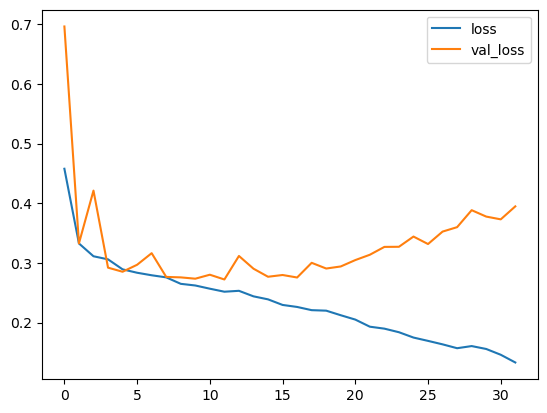

In [8]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

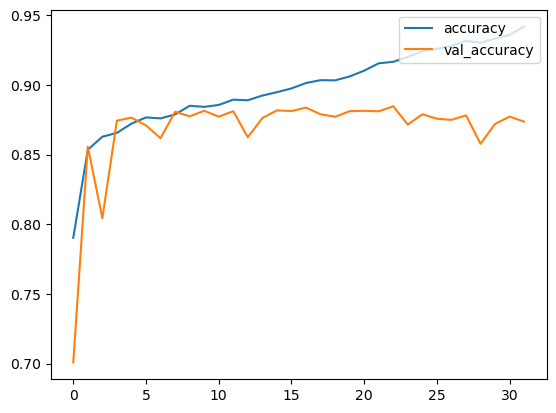

In [9]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [11]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [168]:
loaded_model = keras.models.load_model('pt_id10_25.keras')

In [169]:
initial_model = keras.models.load_model('pt_initial_id10_25.keras')

In [170]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [171]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [172]:
loaded_model.trainable = False

In [233]:
print(loaded_model.layers[5].weights)

[<tf.Variable 'sequential_5_9/dense_8/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00030435, -0.01772699, ..., -0.02740256,
        -0.02138304, -0.01782336],
       [ 0.04094961,  0.05507887,  0.02192558, ...,  0.01142774,
         0.06550565, -0.03992231],
       [-0.06440324,  0.0638316 ,  0.04577684, ...,  0.00208545,
        -0.05588841, -0.01210831],
       ...,
       [ 0.0307514 , -0.01207008, -0.06143984, ..., -0.04826026,
         0.03134148,  0.00919251],
       [ 0.05978832,  0.00203153, -0.02276526, ..., -0.03255004,
        -0.03657148,  0.01606582],
       [-0.05766067,  0.06299955, -0.0452524 , ...,  0.05907474,
        -0.00846294,  0.00063005]], dtype=float32)>, <tf.Variable 'sequential_5_9/dense_8/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [174]:
print(loaded_model.layers[4].weights[0])

<tf.Variable 'sequential_4_9/conv2d_8/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 4.51480374e-02, -9.47153643e-02, -6.01854660e-02, ...,
          -4.29594517e-03, -1.06433276e-02,  1.35797625e-02]],

        [[-1.19837122e-02, -1.15571447e-01, -4.89050820e-02, ...,
          -5.41335121e-02, -1.22078275e-02,  1.61129341e-04]],

        [[ 2.45725904e-02, -1.32688269e-01, -9.51554477e-02, ...,
          -1.87368710e-02,  8.32325430e-04, -9.92666483e-02]],

        [[-9.04641002e-02, -1.35849640e-01, -1.32281080e-01, ...,
           3.76660414e-02,  5.41339256e-02,  1.49958581e-02]],

        [[ 3.76928598e-02,  1.20774759e-02,  1.40193775e-02, ...,
          -1.00578912e-01,  1.36562053e-03, -6.36685193e-02]]],


       [[[-4.94831540e-02,  3.35765071e-03, -1.40786842e-02, ...,
          -5.43256290e-02, -6.10701814e-02, -2.16937829e-02]],

        [[-7.94401094e-02, -7.81050324e-02, -2.83638593e-02, ...,
          -3.27701680e-02,  1.75190996e-02,  1.47177139e-02]],

In [175]:
initial_weights = initial_model.layers[5].get_weights()
loaded_model.layers[5].set_weights(initial_weights)

In [176]:
print(loaded_model.layers[5].weights[0])

<tf.Variable 'sequential_5_9/dense_8/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00030435, -0.01772699, ..., -0.02740256,
        -0.02138304, -0.01782336],
       [ 0.04094961,  0.05507887,  0.02192558, ...,  0.01142774,
         0.06550565, -0.03992231],
       [-0.06440324,  0.0638316 ,  0.04577684, ...,  0.00208545,
        -0.05588841, -0.01210831],
       ...,
       [ 0.0307514 , -0.01207008, -0.06143984, ..., -0.04826026,
         0.03134148,  0.00919251],
       [ 0.05978832,  0.00203153, -0.02276526, ..., -0.03255004,
        -0.03657148,  0.01606582],
       [-0.05766067,  0.06299955, -0.0452524 , ...,  0.05907474,
        -0.00846294,  0.00063005]], dtype=float32)>


In [ ]:
#Fine-tuning on data
n_train_sr_bkg = 25000
n_train_sr_bkg_ft = 25000
rng = np.random.default_rng(seed=42)
mean_results = []
std_results = []
for p_1 in [25,50,75]:
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = keras.models.load_model(f'pt_id10_{p_1}.keras')    
    initial_model = keras.models.load_model(f'pt_initial_id10_{p_1}.keras')    
    initial_weights = initial_model.layers[5].get_weights()
    loaded_model.layers[5].set_weights(initial_weights)
    loaded_model.trainable = False    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg = int(np.round(n_train_sr_bkg*sb_sr_bkg))
    #First jet, background, SR
    bkg_train_sr_1 = bkg_sr_jet_1[n_train_sr_bkg:n_train_sr_bkg+n_train_sr_bkg_ft]
    #Second jet, background, SR
    bkg_train_sr_2 = bkg_sr_jet_2[n_train_sr_bkg:n_train_sr_bkg+n_train_sr_bkg_ft]
    #First jet, background, SB
    bkg_train_sb_1 = bkg_sb_jet_1[0:n_train_sb_bkg]
    #Second jet, background, SB
    bkg_train_sb_2 = bkg_sb_jet_2[0:n_train_sb_bkg]
    
    signal_sr_jet_1 = np.load(f'id10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'id10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'id10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'id10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        
        #First jet, signal, SR
        signal_train_sr_1 = signal_sr_jet_1[0:n_train_sr_signal]
        
        #Second jet, signal, SR
        signal_train_sr_2 = signal_sr_jet_2[0:n_train_sr_signal]

        #First jet, signal, SB
        signal_train_sb_1 = signal_sb_jet_1[0:n_train_sb_signal]

        #Second jet, signal, SB
        signal_train_sb_2 = signal_sb_jet_2[0:n_train_sb_signal]
        
        train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
        train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))

        train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)
        
        train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
        train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))

        train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)
        
        x_train_1 = np.concatenate((train_sr_1, train_sb_1))
        x_train_2 = np.concatenate((train_sr_2, train_sb_2))
        y_train = np.concatenate((train_label_sr, train_label_sb))
        
        #Mix up the samples
        indices = rng.permutation(np.shape(y_train)[0])
        
        x_train_1 = x_train_1[indices]
        x_train_2 = x_train_2[indices]
        y_train = y_train[indices]
        
        x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
        x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))
    
        epsilon_results = []
        for i in range(10):
            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = keras.models.clone_model(loaded_model)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            cwola_ft.save(f'/home/manhducnmd/pp_dijet/Model_results/ft_run_{i}_id10_{n_train_sr_signal}_{p_1}.keras')
    

Training with significance = 0.32, run 0
Train on 40334 samples, validate on 10084 samples
Epoch 1/1000
40334/40334 [==============================] - 7s 169us/sample - loss: 0.7351 - accuracy: 0.5090 - val_loss: 0.7055 - val_accuracy: 0.5039
Epoch 2/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6960 - accuracy: 0.5097 - val_loss: 0.6940 - val_accuracy: 0.5111
Epoch 3/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6935 - accuracy: 0.5123 - val_loss: 0.6938 - val_accuracy: 0.5083
Epoch 4/1000
40334/40334 [==============================] - 4s 90us/sample - loss: 0.6928 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.5116
Epoch 5/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6924 - accuracy: 0.5153 - val_loss: 0.6934 - val_accuracy: 0.5130
Epoch 6/1000
40334/40334 [==============================] - 4s 93us/sample - loss: 0.6921 - accuracy: 0.5160 - val_loss: 0.6932 - val_accuracy: 0.5140
Ep

40334/40334 [==============================] - 4s 93us/sample - loss: 0.6893 - accuracy: 0.5340 - val_loss: 0.6949 - val_accuracy: 0.5105
Epoch 18/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6890 - accuracy: 0.5337 - val_loss: 0.6939 - val_accuracy: 0.5120
Epoch 19/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6886 - accuracy: 0.5355 - val_loss: 0.6948 - val_accuracy: 0.5103
Epoch 20/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6880 - accuracy: 0.5400 - val_loss: 0.6941 - val_accuracy: 0.5038
Epoch 21/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6882 - accuracy: 0.5380 - val_loss: 0.6943 - val_accuracy: 0.5130
Epoch 22/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6873 - accuracy: 0.5432 - val_loss: 0.6947 - val_accuracy: 0.5029
Epoch 23/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6871 - accuracy:

40334/40334 [==============================] - 4s 92us/sample - loss: 0.6790 - accuracy: 0.5678 - val_loss: 0.6972 - val_accuracy: 0.5145
Epoch 35/1000
40334/40334 [==============================] - 4s 90us/sample - loss: 0.6783 - accuracy: 0.5655 - val_loss: 0.6980 - val_accuracy: 0.5081
Epoch 36/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6770 - accuracy: 0.5700 - val_loss: 0.6978 - val_accuracy: 0.5093
Training with significance = 0.32, run 3
Train on 40334 samples, validate on 10084 samples
Epoch 1/1000
40334/40334 [==============================] - 5s 117us/sample - loss: 0.7351 - accuracy: 0.5090 - val_loss: 0.7055 - val_accuracy: 0.5039
Epoch 2/1000
40334/40334 [==============================] - 4s 93us/sample - loss: 0.6960 - accuracy: 0.5096 - val_loss: 0.6940 - val_accuracy: 0.5112
Epoch 3/1000
40334/40334 [==============================] - 4s 93us/sample - loss: 0.6935 - accuracy: 0.5119 - val_loss: 0.6938 - val_accuracy: 0.5096
Epoch 4/1000


Epoch 15/1000
40334/40334 [==============================] - 4s 95us/sample - loss: 0.6899 - accuracy: 0.5308 - val_loss: 0.6935 - val_accuracy: 0.5069
Epoch 16/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6896 - accuracy: 0.5335 - val_loss: 0.6936 - val_accuracy: 0.5135
Epoch 17/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6894 - accuracy: 0.5341 - val_loss: 0.6948 - val_accuracy: 0.5097
Epoch 18/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6891 - accuracy: 0.5342 - val_loss: 0.6939 - val_accuracy: 0.5134
Epoch 19/1000
40334/40334 [==============================] - 4s 89us/sample - loss: 0.6887 - accuracy: 0.5352 - val_loss: 0.6947 - val_accuracy: 0.5114
Epoch 20/1000
40334/40334 [==============================] - 3s 76us/sample - loss: 0.6881 - accuracy: 0.5401 - val_loss: 0.6942 - val_accuracy: 0.5035
Epoch 21/1000
40334/40334 [==============================] - 3s 83us/sample - loss: 0.68

40334/40334 [==============================] - 3s 69us/sample - loss: 0.6818 - accuracy: 0.5593 - val_loss: 0.6966 - val_accuracy: 0.5076
Epoch 32/1000
40334/40334 [==============================] - 4s 89us/sample - loss: 0.6814 - accuracy: 0.5575 - val_loss: 0.6971 - val_accuracy: 0.5062
Epoch 33/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6807 - accuracy: 0.5606 - val_loss: 0.6969 - val_accuracy: 0.5064
Epoch 34/1000
40334/40334 [==============================] - 4s 93us/sample - loss: 0.6792 - accuracy: 0.5659 - val_loss: 0.6971 - val_accuracy: 0.5115
Epoch 35/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6785 - accuracy: 0.5672 - val_loss: 0.6978 - val_accuracy: 0.5065
Epoch 36/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6771 - accuracy: 0.5715 - val_loss: 0.6977 - val_accuracy: 0.5074
Epoch 37/1000
40334/40334 [==============================] - 4s 92us/sample - loss: 0.6768 - accuracy:

Epoch 11/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6911 - accuracy: 0.5226 - val_loss: 0.6935 - val_accuracy: 0.5086
Epoch 12/1000
40334/40334 [==============================] - 4s 91us/sample - loss: 0.6908 - accuracy: 0.5300 - val_loss: 0.6947 - val_accuracy: 0.5069
Epoch 13/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6906 - accuracy: 0.5280 - val_loss: 0.6934 - val_accuracy: 0.5118
Epoch 14/1000
40334/40334 [==============================] - 4s 94us/sample - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6935 - val_accuracy: 0.5136
Epoch 15/1000
16500/40334 [===========>..................] - ETA: 1s - loss: 0.6899 - accuracy: 0.5304

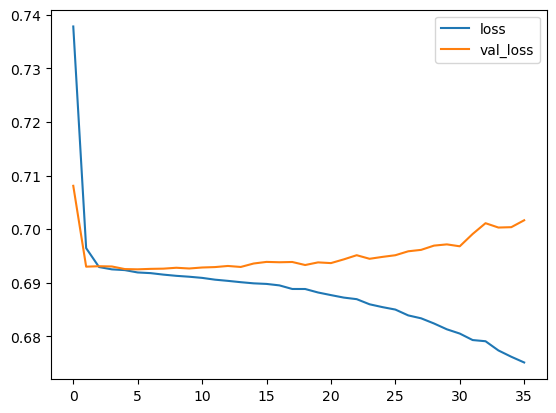

In [200]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

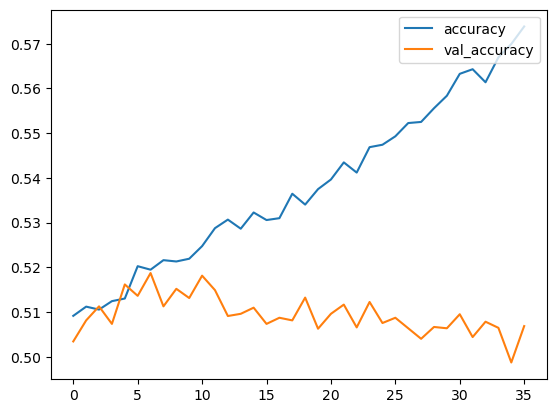

In [201]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [202]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [203]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('id10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('id10_sr_25_jet_2.npy')



In [204]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [223]:
x_predict = cwola_ft.predict([x_test_1, x_test_2])


In [224]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

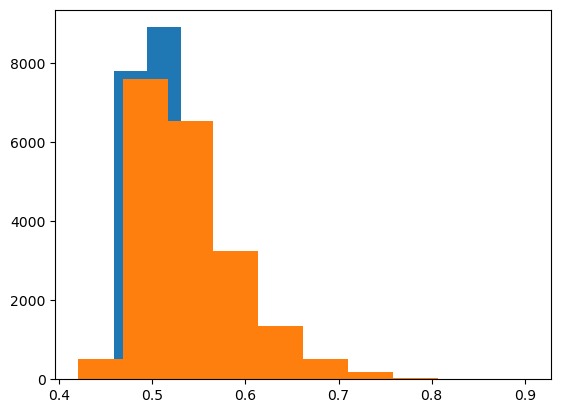

In [225]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

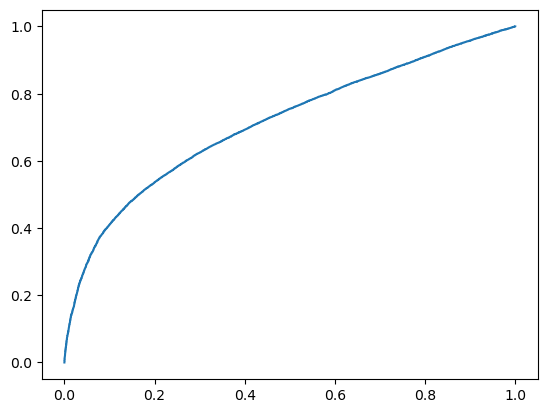

0.7133214674999999


In [226]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [227]:
print(cwola_ft.layers[4].weights[0])

<tf.Variable 'sequential_4_19/conv2d_8/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 4.51480374e-02, -9.47153643e-02, -6.01854660e-02, ...,
          -4.29594517e-03, -1.06433276e-02,  1.35797625e-02]],

        [[-1.19837122e-02, -1.15571447e-01, -4.89050820e-02, ...,
          -5.41335121e-02, -1.22078275e-02,  1.61129341e-04]],

        [[ 2.45725904e-02, -1.32688269e-01, -9.51554477e-02, ...,
          -1.87368710e-02,  8.32325430e-04, -9.92666483e-02]],

        [[-9.04641002e-02, -1.35849640e-01, -1.32281080e-01, ...,
           3.76660414e-02,  5.41339256e-02,  1.49958581e-02]],

        [[ 3.76928598e-02,  1.20774759e-02,  1.40193775e-02, ...,
          -1.00578912e-01,  1.36562053e-03, -6.36685193e-02]]],


       [[[-4.94831540e-02,  3.35765071e-03, -1.40786842e-02, ...,
          -5.43256290e-02, -6.10701814e-02, -2.16937829e-02]],

        [[-7.94401094e-02, -7.81050324e-02, -2.83638593e-02, ...,
          -3.27701680e-02,  1.75190996e-02,  1.47177139e-02]]

In [228]:
print(epsilon_s)

[0.01805 0.10425 0.4101 ]


In [229]:
n_train_sr_signal = 500

In [230]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))

4.046772558182483
